##Importado bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.stats import linregress, pearsonr, spearmanr
from scipy.signal import periodogram

#Carregamento dos Dados

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/GuiMendeees/UFMG/master/Monografia%20I/World_Development_Indicators.csv'
  ,encoding = 'latin'
  ,sep = ';')

In [ ]:
data = data.loc[data['COD_PAIS'] == 'BRA']

In [ ]:
years = data['ANO']

In [ ]:
data = data.fillna(data.median())

<ipython-input-5-1ed84e2e0a3e>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.median())


In [ ]:
data = np.array(data['POP_TOTAL'])

##Tratamento dos Dados

In [ ]:
data_norm = (data - data.min()) / (data.max() - data.min())

In [ ]:
data_esc = data/(10**9)

In [ ]:
data_esc[0]

0.073092515

#Modelos Matemáticos

##Mapa Logistico

<ipython-input-10-c95083fa1986>:3: RuntimeWarning: overflow encountered in double_scalars
  return r * X * (1 - X)
<ipython-input-10-c95083fa1986>:13: RuntimeWarning: overflow encountered in square
  return np.sum((data_esc - res) ** 2)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


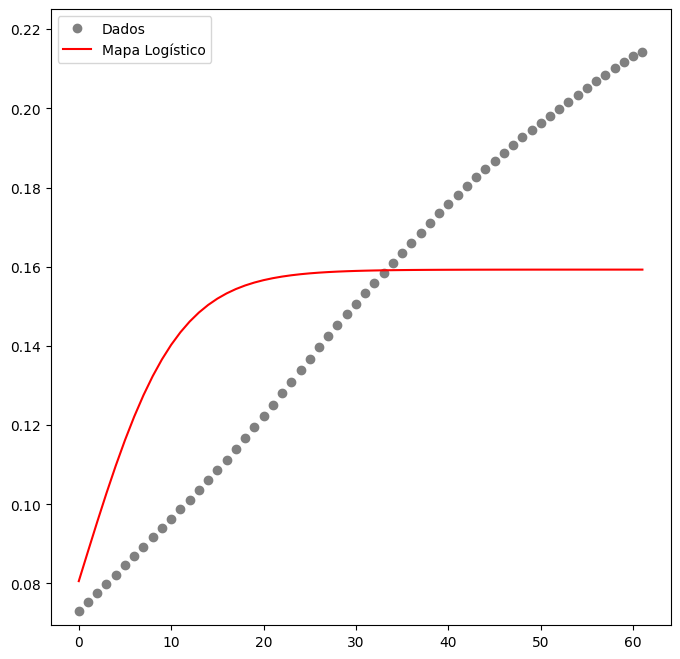

In [ ]:
# Função logística
def logistic_map(r, X):
    return r * X * (1 - X)

# Função de soma dos quadrados das diferenças
def sum_of_squares(params):
    r = params[0]
    X = data_esc[0]
    res = []
    for i in range(len(data_esc)):
        X = logistic_map(r, X)
        res.append(X)
    return np.sum((data_esc - res) ** 2)

# Encontrando o valor ótimo de "r"
result = minimize(sum_of_squares, [3.0])
optimal_r = result.x[0]

# Gerando a curva ajustada
X = data_esc[0]
res = []
for i in range(len(data_esc)):
#for i in range (100):
    X = logistic_map(optimal_r, X)
    res.append(X)

plt.rcParams['figure.figsize']  = (8, 8)
# Plotando os resultados
plt.plot(data_esc, 'o', label='Dados',color='grey')
plt.plot(res, label='Mapa Logístico',color='red')
plt.ylim([data_esc[0]*0.95, max(data_esc) * 1.05])
plt.legend()
plt.show()

#plt.rcParams['figure.figsize']  = (6.4, 4.8)
#len(res)

In [ ]:
#res

In [ ]:
print(f"Valor otimo de R: {optimal_r}")
print(f"Conjunto de Dados Tamanho da Série: {len(data_esc)}")
print(f"Mapa Logístico Tamanho da Série: {len(res)}")

Valor otimo de R: 1.189459396992566
Conjunto de Dados Tamanho da Série: 62
Mapa Logístico Tamanho da Série: 62


##Gompertz

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# Definir a equação diferencial de Bertalanffy-Richards
def gompertz(N,t,r,K):
    return -r*N*np.log(N/K)

# Dados experimentais
t_experimentalG = np.arange(1, len(data_esc) + 1)
N_experimentalG = np.array(data_esc)

# Resolver a equação diferencial de Bertalanffy-Richards
def solve_gompertz(t, r,K):
    N0 = N_experimentalG[0]
    solution = odeint(gompertz, N0, t, args=(r, K))
    return solution.flatten()

# Ajustar a curva aos dados
popt, pcov = curve_fit(solve_gompertz, t_experimentalG, N_experimentalG, maxfev=100000)

# Parâmetros otimizados
r_opt, k_opt = popt

<ipython-input-13-59f3f01a9674>:7: RuntimeWarning: invalid value encountered in log
  return -r*N*np.log(N/K)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:
print(f"Valor otimo de r: {popt[0]}")
print(f"Valor otimo de K: {popt[1]}")

Valor otimo de r: 0.022778791293783192
Valor otimo de K: 0.3116868661555253


In [ ]:
#Variâncias estimadas dos parâmetros
pcov

array([[ 1.38064305e-07, -1.54192615e-06],
       [-1.54192615e-06,  1.76451753e-05]])

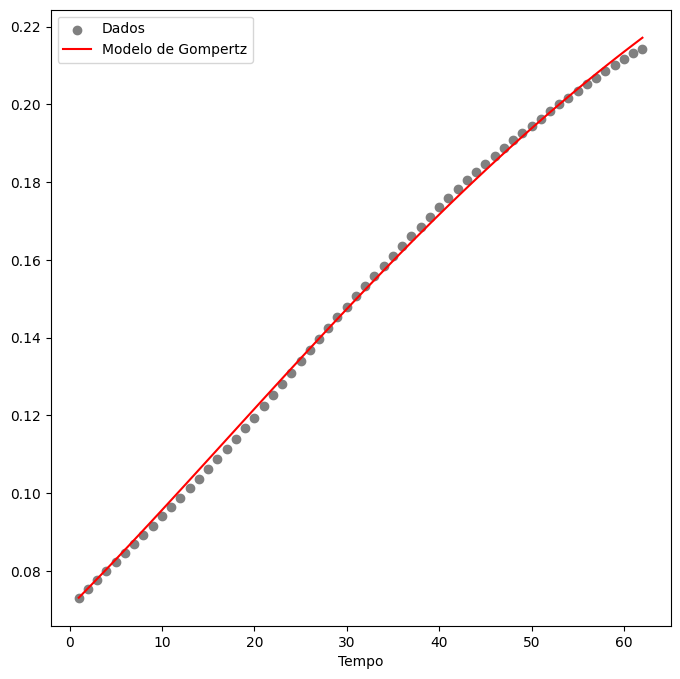

In [ ]:
# Gerar curva com os parâmetros otimizados
t_curvaG = np.linspace(t_experimentalG[0], t_experimentalG[-1], len(t_experimentalG))
N_curvaG = solve_gompertz(t_curvaG, r_opt, k_opt)

# Plotar dados experimentais e curva gerada
#plt.plot(t_curva, t_curva, 'ro', label='Curva Gerada')
plt.scatter(t_experimentalG, N_experimentalG, label='Dados',color='grey')
plt.plot(t_curvaG, N_curvaG, color='red', label='Modelo de Gompertz')
plt.xlabel('Tempo')
#plt.ylabel('N')
plt.legend()
#plt.title('Curva de Gompertz')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular o erro médio absoluto (MAE) e o erro médio quadrático (MSE)
mae = mean_absolute_error(N_experimentalG, N_curvaG)
mse = mean_squared_error(N_experimentalG, N_curvaG)

print('MAE:', mae)
print('MSE:', mse)

MAE: 0.001299899723834743
MSE: 2.2278114690412455e-06


##Bertalanffy-Richards

In [ ]:
#!pip install  pygrowthmodels

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# Definir a equação diferencial de Bertalanffy-Richards
def bertalanffy_richards(N, t, a, b, beta):
    return (a * N**beta) - (b * N)

# Dados experimentais
t_experimentalBR = np.arange(1, len(data_esc) + 1)
N_experimentalBR = np.array(data_esc)

# Resolver a equação diferencial de Bertalanffy-Richards
def solve_bertalanffy_richards(t, a, b, beta):
    N0 = N_experimentalBR[0]
    solutionBR = odeint(bertalanffy_richards, N0, t, args=(a, b, beta))
    return solutionBR.flatten()

# Ajustar a curva aos dados
popt, pcov = curve_fit(solve_bertalanffy_richards, t_experimentalBR, N_experimentalBR, maxfev=50000)

# Parâmetros otimizados
a_opt, b_opt, beta_opt = popt

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-19-880c9c4f744c>:7: RuntimeWarning: invalid value encountered in power
  return (a * N**beta) - (b * N)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:
print(f"Valor otimo de a: {popt[0]}")
print(f"Valor otimo de b: {popt[1]}")
print(f"Valor otimo de beta: {popt[2]}")

Valor otimo de a: 0.9395686866457748
Valor otimo de b: 0.9650904831374422
Valor otimo de beta: 0.9768607716873631


In [ ]:
#Variâncias estimadas dos parâmetros
pcov

array([[1.94296960e+01, 1.94448936e+01, 4.59953203e-01],
       [1.94448936e+01, 1.94601037e+01, 4.60312705e-01],
       [4.59953203e-01, 4.60312705e-01, 1.08884668e-02]])

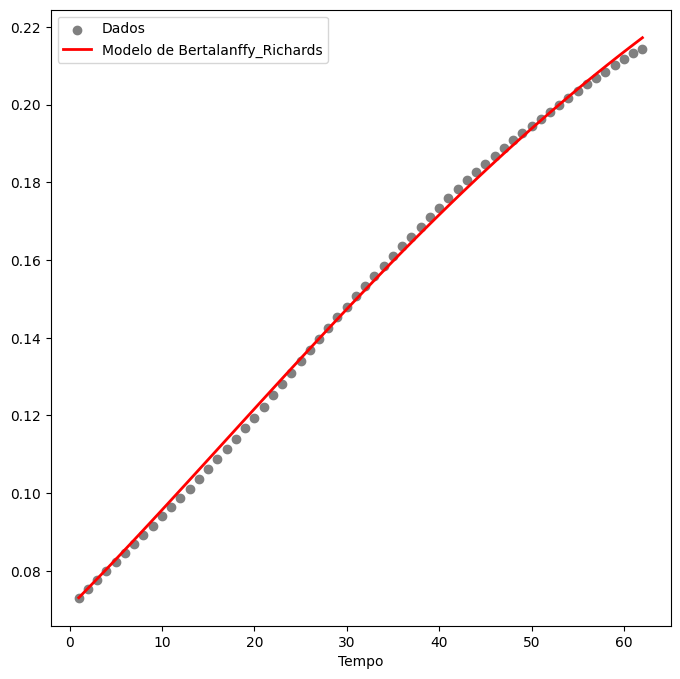

In [ ]:
# Gerar curva com os parâmetros otimizados Gompertz
t_curvaG = np.linspace(t_experimentalG[0], t_experimentalG[-1], len(t_experimentalG))
N_curvaG = solve_gompertz(t_curvaG, r_opt, k_opt)

# Gerar curva com os parâmetros otimizados Bertalanffy_Richards
t_curvaBR = np.linspace(t_experimentalBR[0], t_experimentalBR[-1], len(t_experimentalBR))
N_curvaBR = solve_bertalanffy_richards(t_curvaBR, a_opt, b_opt, beta_opt)

# Plotar dados experimentais e curva gerada
#plt.plot(t_curva, t_curva, 'ro', label='Curva Gerada')
plt.scatter(t_experimentalBR, N_experimentalBR, color = 'grey',label='Dados')
plt.plot(t_curvaBR, N_curvaBR, color='red', label='Modelo de Bertalanffy_Richards', linewidth=2)
#plt.plot(t_curvaG, N_curvaG, color='blue', label='Modelo de Gompertz', linestyle='dashed',linewidth=2)
plt.xlabel('Tempo')
#plt.ylabel('N')
plt.legend()
#plt.title('Ajuste de Curvas')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular o erro médio absoluto (MAE) e o erro médio quadrático (MSE)
mae = mean_absolute_error(N_experimentalBR, N_curvaBR)
mse = mean_squared_error(N_experimentalBR, N_curvaBR)

print('MAE:', mae)
print('MSE:', mse)

MAE: 0.001318989307175318
MSE: 2.2907486057900644e-06


In [ ]:
N_experimentalBR

array([0.07309251, 0.07533001, 0.07759922, 0.07991555, 0.08226279,
       0.08462375, 0.08697928, 0.08932329, 0.09165925, 0.09400038,
       0.09636987, 0.09876629, 0.10119439, 0.1036669 , 0.10616737,
       0.10870051, 0.1112865 , 0.11393989, 0.11666438, 0.1194473 ,
       0.12228838, 0.12516806, 0.12806509, 0.13097737, 0.13388877,
       0.13678318, 0.13964335, 0.14246626, 0.14525397, 0.14800341,
       0.15070645, 0.15333644, 0.15590079, 0.15844088, 0.16098047,
       0.16351533, 0.16603712, 0.16854671, 0.1710398 , 0.17348628,
       0.17587372, 0.17821188, 0.18047668, 0.18262928, 0.18472204,
       0.18679733, 0.18882068, 0.19077945, 0.19267232, 0.19451755,
       0.19635349, 0.1981853 , 0.19997771, 0.20172177, 0.20345965,
       0.20518821, 0.20685958, 0.20850496, 0.21016659, 0.21178288,
       0.2131963 , 0.21432622])

In [ ]:
N_curvaBR

array([0.07309251, 0.07552442, 0.07797901, 0.08045468, 0.08294986,
       0.08546298, 0.08799246, 0.09053675, 0.0930943 , 0.09566356,
       0.09824301, 0.10083116, 0.10342651, 0.10602761, 0.10863302,
       0.11124133, 0.11385117, 0.11646117, 0.11907003, 0.12167644,
       0.12427916, 0.12687697, 0.12946867, 0.13205312, 0.13462921,
       0.13719586, 0.13975202, 0.1422967 , 0.14482894, 0.14734781,
       0.14985243, 0.15234193, 0.1548155 , 0.15727237, 0.1597118 ,
       0.16213309, 0.16453557, 0.16691862, 0.16928162, 0.17162404,
       0.17394533, 0.17624501, 0.17852261, 0.18077771, 0.18300991,
       0.18521885, 0.18740418, 0.18956561, 0.19170284, 0.19381563,
       0.19590376, 0.19796701, 0.20000523, 0.20201825, 0.20400595,
       0.20596823, 0.207905  , 0.2098162 , 0.21170178, 0.21356173,
       0.21539604, 0.21720472])

#Testes

##Autocorrelação

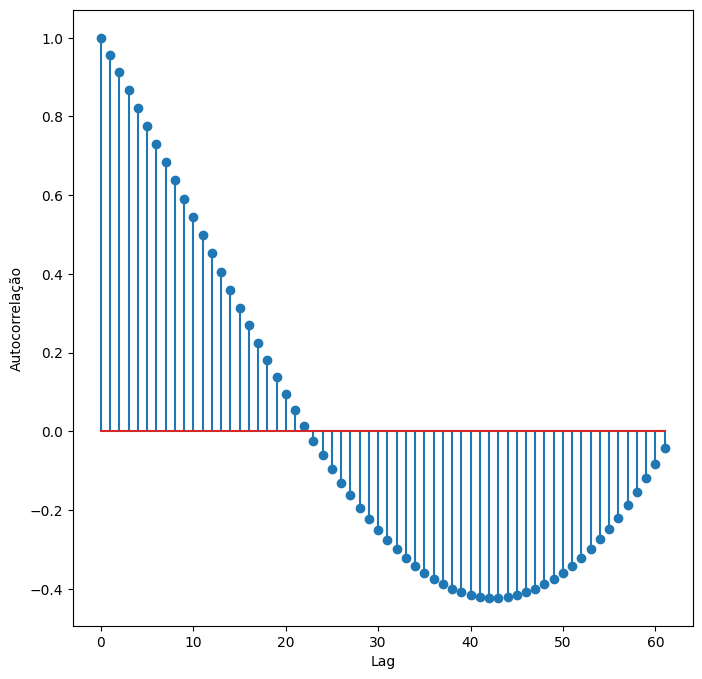

In [ ]:
def autocorrelacao(data):
    n = len(data)
    mean = np.mean(data)
    data_central = data - mean

    autocorr = np.correlate(data_central, data_central, mode='full')[-n:]
    autocorr /= autocorr[0]  # Normalização pelo valor da autocorrelação no lag 0

    return autocorr


autocorr = autocorrelacao(data_esc)

# Plot da autocorrelação
lags = np.arange(len(autocorr))
plt.stem(lags, autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
#plt.title('Autocorrelation Plot')
plt.show()

In [ ]:
autocorr

array([ 1.        ,  0.95636891,  0.91196848,  0.86700798,  0.82166527,
        0.77602223,  0.7301165 ,  0.68399766,  0.63772945,  0.5913517 ,
        0.54491148,  0.49849533,  0.45218506,  0.40604691,  0.36015937,
        0.31461318,  0.26951385,  0.22498089,  0.1811382 ,  0.13809492,
        0.09597775,  0.05494468,  0.01512135, -0.02339249, -0.06049217,
       -0.09608978, -0.13012467, -0.1625502 , -0.19332196, -0.22239966,
       -0.24974812, -0.27532478, -0.2990818 , -0.32096313, -0.34090122,
       -0.35881757, -0.37463786, -0.38829185, -0.39971049, -0.40883737,
       -0.41564526, -0.42012531, -0.42226508, -0.42208132, -0.41962935,
       -0.41493341, -0.4079992 , -0.39885414, -0.38752755, -0.37404016,
       -0.35839977, -0.34059973, -0.32062353, -0.29847558, -0.27416796,
       -0.24767325, -0.21895878, -0.1880214 , -0.15484202, -0.1193853 ,
       -0.0816659 , -0.04181196])

##Estacionariedade

In [ ]:
# Tamanho da janela móvel
tamanho_janela = 6

# Verificar a estacionaridade em cada janela móvel
estacionaridade = []
for i in range(len(data_esc) - tamanho_janela + 1):
    janela = data_esc[i:i + tamanho_janela]
    media_janela = np.mean(janela)
    variancia_janela = np.var(janela)

    media_total = np.mean(data_esc)
    variancia_total = np.var(data_esc)

    # Verificar se a média e a variância da janela estão dentro de um desvio padrão da média e variância total
    if abs(media_janela - media_total) <= np.sqrt(variancia_total) and abs(variancia_janela - variancia_total) <= np.sqrt(variancia_total):
        estacionaridade.append(True)
    else:
        estacionaridade.append(False)
    #print(f"Passo {i}")
    #print(f"Media Total: {media_total}")
    #print(f"Media Total - 1Dp: {media_total-np.sqrt(variancia_total)}")
    #print(f"Media Janela: {media_janela}")
    #print(f"Media Total + 1Dp: {media_total+np.sqrt(variancia_total)}")

    #print(f"Variancia Total: {variancia_total}")
    #print(f"Variancia Total - 1Dp: {variancia_total-np.sqrt(variancia_total)}")
    #print(f"Variancia Janela: {variancia_janela}")
    #print(f"Variancia Total + 1Dp: {variancia_total+np.sqrt(variancia_total)}")


# Verificar se todas as janelas móveis são estacionárias
eh_estacionaria = all(estacionaridade)

# Imprimir os resultados
print("A série temporal é estacionária?", eh_estacionaria)

A série temporal é estacionária? False


Avaliando tendência

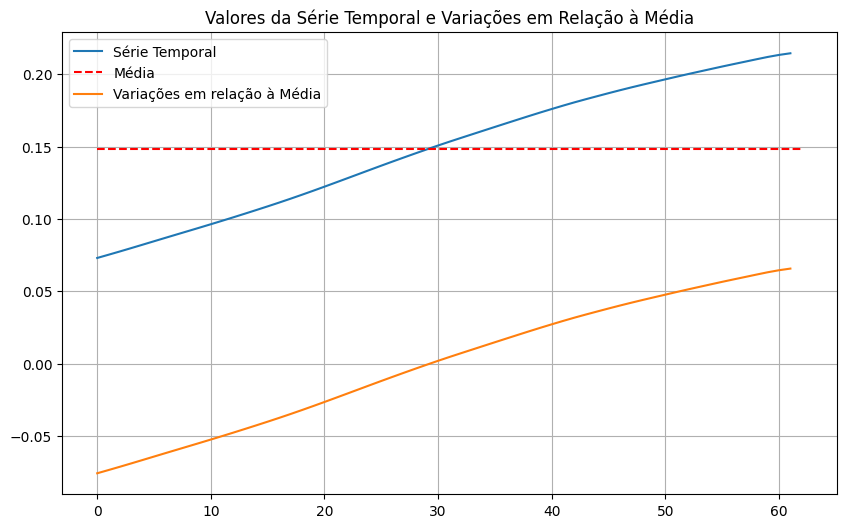

In [ ]:
# Calcular a média da série temporal
media = np.mean(data_esc)

# Calcular a diferença entre cada valor e a média
diferencas = data_esc - media

# Plotar a série temporal e as variações em relação à média
plt.figure(figsize=(10, 6))
plt.plot(data_esc, label='Série Temporal')
plt.plot([0, len(data_esc)], [media, media], color='red', linestyle='--', label='Média')
plt.plot(diferencas, label='Variações em relação à Média')
plt.legend()
plt.title('Valores da Série Temporal e Variações em Relação à Média')
plt.grid(True)
plt.show()

Comparativo Lorenz

In [ ]:
import numpy as np
from scipy.integrate import odeint

# Parâmetros das equações de Lorenz
sigma = 10.0
rho = 28.0
beta = 8/3

# Função que define as equações de Lorenz
def lorenz_eqs(X, t):
    x, y, z = X
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

# Condições iniciais
x0, y0, z0 = [5.0, 5.0, 5.0]

# Parâmetros do método de janelas móveis
tamanho_janela = 200
intervalo_deslocamento = 100

# Valores de tempo
t = np.arange(0, 10000)

# Lista para armazenar os resultados da estacionaridade
estacionaridade = []

# Aplicar o cálculo de estacionaridade em cada janela móvel
for i in range(0, len(t) - tamanho_janela + 1, intervalo_deslocamento):
    t_janela = t[i:i + tamanho_janela]
    X_janela = odeint(lorenz_eqs, [x0, y0, z0], t_janela)

    media_janela = np.mean(X_janela[:, 0])
    variancia_janela = np.var(X_janela[:, 0])

    media_total = np.mean(X_janela[:, 0])
    variancia_total = np.var(X_janela[:, 0])

    # Verificar se a média e a variância da janela estão dentro de um desvio padrão da média e variância total
    if abs(media_janela - media_total) <= np.sqrt(variancia_total) and abs(variancia_janela - variancia_total) <= np.sqrt(variancia_total):
        estacionaridade.append(True)
    else:
        estacionaridade.append(False)
    #print(f"Passo {i}")
    #print(f"Media Total: {media_total}")
    #print(f"Media Total - 1Dp: {media_total-np.sqrt(variancia_total)}")
    #print(f"Media Janela: {media_janela}")
    #print(f"Media Total + 1Dp: {media_total+np.sqrt(variancia_total)}")

    #print(f"Variancia Total: {variancia_total}")
    #print(f"Variancia Total - 1Dp: {variancia_total-np.sqrt(variancia_total)}")
    #print(f"Variancia Janela: {variancia_janela}")
    #print(f"Variancia Total + 1Dp: {variancia_total+np.sqrt(variancia_total)}")


# Verificar se todas as janelas móveis são estacionárias
eh_estacionaria = all(estacionaridade)

# Imprimir os resultados
print("A série temporal é estacionária?", eh_estacionaria)

A série temporal é estacionária? True


##Teorema de Takens

In [ ]:
!pip install pyEDM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 kB 25.6 MB/s eta 0:00:00


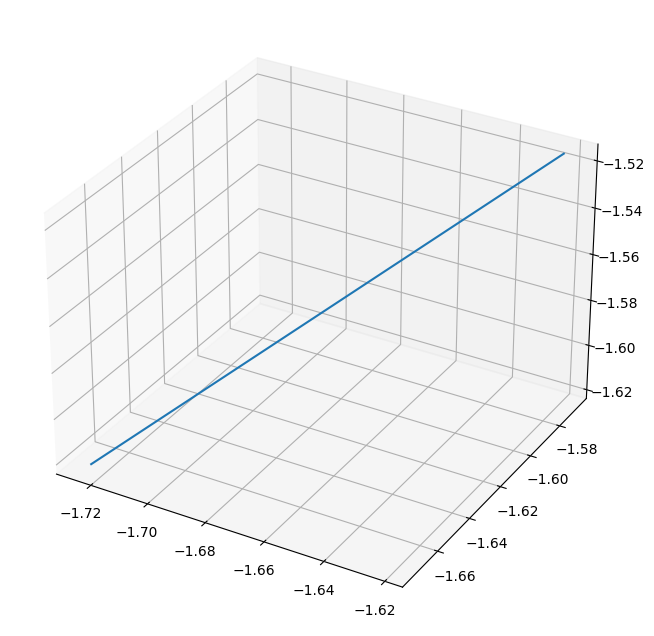

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Parâmetros para o espaço de fase embutido
dimensao = 3   # Dimensão do espaço de fase
atraso = 2   # Atraso entre as amostras

# Preparar os dados para o espaço de fase embutido
data = np.array(data_esc)
scaler = StandardScaler()
data_norm = scaler.fit_transform(data.reshape(-1, 1))

# Criar o espaço de fase embutido
embedded_space = np.column_stack([data_norm[i:i+dimensao].flatten() for i in range(len(data_norm)-dimensao+1)])

# Plotar o espaço de fase embutido
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(embedded_space[:, 0], embedded_space[:, 1], embedded_space[:, 2])
#ax.set_xlabel('Dimensão 1')
#ax.set_ylabel('Dimensão 2')
#ax.set_zlabel('Dimensão 3')
plt.show()

In [ ]:
print(len(embedded_space[0]))
print(len(embedded_space[1]))
print(len(embedded_space[2]))

60
60
60


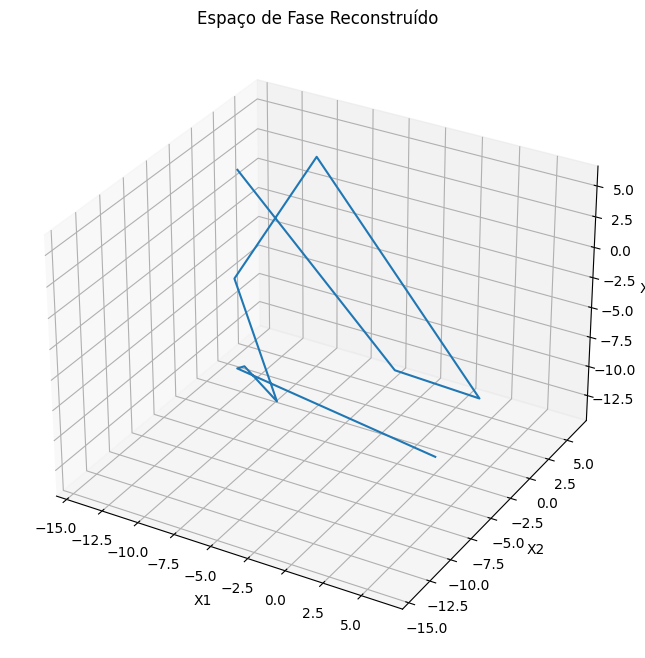

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros das equações de Lorenz
sigma = 10.0
rho = 28.0
beta = 8/3

# Função que define as equações de Lorenz
def lorenz_eqs(X, t):
    x, y, z = X
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

# Condições iniciais
x0, y0, z0 = [5.0, 5.0, 5.0]

# Parâmetros de reconstrução do espaço de fase
embedding_dim = 9
time_delay = 1

# Dados de tempo
t = np.arange(0, 10000, 1)

# Simulação das equações de Lorenz
X = odeint(lorenz_eqs, [x0, y0, z0], t)

# Extrair a variável x para a reconstrução do espaço de fase
x = X[:, 0]

# Reconstrução do espaço de fase usando o Teorema de Takens
embedded_data = np.column_stack([x[i:(i + embedding_dim)] for i in range(len(x) - embedding_dim * time_delay + 1)])

# Plotar o espaço de fase reconstruído
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Espaço de Fase Reconstruído')

plt.show()